### Run basic `scanpy` QC and doublet detection with `scrublet` for **PBMC Tuberculosis** _Nathan et al 2021_

- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Mairi McClean
- **Computational Health Centre - Helmholtz Munich**
- ORIGINAL: v221101; MODIFIED: v221117

In [5]:
import os 
os.write(1, b"text\n")

text


5

### Load required modules

In [6]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [7]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.7.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fsspec                      2022.3.0
h5py                        3.7.0
ipykernel                   6.9.1
ipython_genutils            0.2.0
ipywidgets                  7.6.5
jedi                        0.18.1
jinja2                      3.0.3
joblib                      1.1.0
jupyter_server              1.18.1
kiwisolver                  1.4.2
llv

### Read datasets

In [8]:
adata = sc.read_h5ad('/lustre/groups/talaveralopez/datasets/mairi_tb_curation/TB/Lung_TB_T_Cells_CITESEQ_RNA.h5ad')
adata

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

In [9]:
adata.obs['donor'].value_counts()

TB6692076    5487
TB6361266    5403
TB0763419    4489
TB5758296    4225
TB6448199    4224
             ... 
TB8805781     234
TB0414005     234
TB8797251     202
TB5742418     114
TB4817029      72
Name: donor, Length: 259, dtype: int64

In [10]:
adata.var_names_make_unique()
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor'

### Filter cells with less than 200 genes

In [11]:
sc.pp.filter_cells(sample_object, min_genes = 200)
print(sample_object.n_obs, sample_object.n_vars)

500089 33538


In [12]:
sample_object.shape

(500089, 33538)

In [13]:
sample_object.var

""
MIR1302-2HG
FAM138A
OR4F5
AL627309.1
AL627309.3
...
AC233755.2
AC233755.1
AC240274.1
AC213203.1


### Compute QC stats

In [14]:
sample_object.shape

(500089, 33538)

In [15]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('MT-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("RPS","RPL"))
sample_object.var

,mt,ribo
MIR1302-2HG,False,False
FAM138A,False,False
OR4F5,False,False
AL627309.1,False,False
AL627309.3,False,False
...,...,...
AC233755.2,False,False
AC233755.1,False,False
AC240274.1,False,False
AC213203.1,False,False


In [16]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

In [17]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('MT-')
sample_object.obs['percent_mt2'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1).A1

In [18]:
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC metrics

In [19]:
sample_object.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
       'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
      dtype='object', length=33538)

In [20]:
sample_object.obs

,cell_id,nUMI,nGene,percent_mito,batch,TB_status,UMAP_1,UMAP_2,cluster_name,cluster_ids,donor,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,percent_mt2,n_counts
0,AAACCCAAGGCCTAAG-1,6108,1557,0.055828,1,CASE,-2.743703,1.617194,CD4+ CD27+,C-2,TB3419057,1557,1557,6108.0,341.0,5.582842,2469.0,40.422398,0.055828,6108.0
1,AAACCCAAGGTTCTTG-1,7902,2149,0.083017,1,CASE,-4.237045,0.306832,CD4+ CCR4+ central,C-3,TB3419057,2149,2149,7902.0,656.0,8.301696,2759.0,34.915211,0.083017,7902.0
2,AAACCCAAGTGCAGGT-1,5033,1788,0.129744,1,CASE,-1.136187,-4.012949,CD4+ Treg,C-9,TB3419057,1788,1788,5033.0,653.0,12.974369,1289.0,25.610968,0.129744,5033.0
3,AAACCCACAAGAGTAT-1,6574,1747,0.066930,1,CASE,-1.015078,3.789505,CD4+ CD27+CD161+,C-4,TB3419057,1747,1747,6574.0,440.0,6.693033,2674.0,40.675388,0.066930,6574.0
4,AAACCCACACACGGTC-1,6471,1872,0.047442,1,CASE,0.658381,2.427080,CD4+ Th17/1,C-13,TB0610655,1872,1872,6471.0,307.0,4.744244,2310.0,35.697727,0.047442,6471.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500084,TTTGTTGTCCGCCTAT-46,1945,833,0.183033,46,CASE,-2.568426,0.780417,CD4+ CD27+,C-2,TB9334348,833,833,1945.0,356.0,18.303343,114.0,5.861183,0.183033,1945.0
500085,TTTGTTGTCCTGGGTG-46,4534,1537,0.051610,46,CONTROL,1.017550,-0.594416,CD4+ Th1,C-17,TB2792656,1537,1537,4534.0,234.0,5.161005,1161.0,25.606527,0.051610,4534.0
500086,TTTGTTGTCGATGGAG-46,3157,1013,0.081723,46,CASE,2.301589,0.623997,CD4+ Th17/1,C-16,TB7198118,1013,1013,3157.0,258.0,8.172316,1231.0,38.992714,0.081723,3157.0
500087,TTTGTTGTCGTTTACT-46,3675,1202,0.089252,46,CASE,0.572390,-1.264730,CD4+ Th1,C-17,TB9334348,1202,1202,3675.0,328.0,8.925170,1167.0,31.755102,0.089252,3675.0


In [22]:
sc.pl.violin(sample_object, ['n_genes', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

In [23]:
# Organized by disease status as sample size is too large to do by sample

sc.pl.violin(sample_object, ['n_genes', 'total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

In [24]:
sample_object.obs.value_counts('cluster_ids')

cluster_ids
C-4     45519
C-2     40431
C-17    37566
C-3     28951
C-6     27770
C-7     26701
C-9     25270
C-23    23213
C-11    20696
C-16    20191
C-8     19901
C-19    17731
C-10    17321
C-29    17085
C-12    16987
C-28    15225
C-14    13662
C-13    13216
C-22     9320
C-24     8319
C-30     8144
C-15     8072
C-18     6768
C-25     6398
C-20     5798
C-1      4891
C-26     4343
C-21     4241
C-5      3255
C-27     2508
C-31      336
dtype: int64

In [25]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "TB_status")

In [26]:
sc.pl.scatter(sample_object, x='total_counts', y='n_genes_by_counts', color = "TB_status")

### Add sample sex covariate

In [28]:
annot = sc.queries.biomart_annotations(
        "hsapiens",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [29]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
MT-TF,ENSG00000210049,577,647,MT
MT-RNR1,ENSG00000211459,648,1601,MT
MT-TV,ENSG00000210077,1602,1670,MT
MT-RNR2,ENSG00000210082,1671,3229,MT
MT-TL1,ENSG00000209082,3230,3304,MT


In [30]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['SRY', 'RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'TGIF2LY', 'PCDH11Y',
       'TSPY2', 'LINC00280', 'TTTY1B', 'TTTY2B', 'TTTY21B', 'TTTY7', 'TTTY8B',
       'AMELY', 'TBL1Y', 'TTTY12', 'LINC00279', 'TTTY18', 'TTTY19', 'TTTY11',
       'TTTY20', 'TSPY4', 'TSPY8', 'TSPY3', 'FAM197Y5', 'TSPY1', 'TSPY10',
       'TTTY8', 'TTTY7B', 'TTTY21', 'TTTY2', 'TTTY1', 'TTTY22', 'TTTY23',
       'USP9Y', 'DDX3Y', 'UTY', 'TMSB4Y', 'VCY', 'VCY1B', 'NLGN4Y',
       'NLGN4Y-AS1', 'FAM41AY1', 'FAM224B', 'CDY2B', 'CDY2A', 'FAM224A',
       'FAM41AY2', 'HSFY1', 'TTTY9B', 'HSFY2', 'TTTY14', 'KDM5D', 'TTTY10',
       'EIF1AY', 'RPS4Y2', 'PRORY', 'RBMY1B', 'RBMY1A1', 'TTTY13', 'RBMY1D',
       'RBMY1E', 'PRY2', 'TTTY6B', 'RBMY1F', 'TTTY5', 'RBMY1J', 'TTTY6', 'PRY',
       'TTTY17A', 'TTTY4', 'BPY2', 'DAZ1', 'DAZ2', 'TTTY3B', 'CDY1B',
       'TTTY17B', 'TTTY4B', 'BPY2B', 'DAZ3', 'DAZ4', 'BPY2C', 'TTTY4C',
       'TTTY17C', 'CDY1', 'TTTY3'],
      dtype='object')

In [31]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1).A1 / np.sum(sample_object.X, axis = 1).A1 * 100

In [33]:
sample_object.obs["XIST-counts"] = sample_object.X[:,sample_object.var_names.str.match('XIST')].toarray()

### Calculate cell cycle scores

In [34]:
!if [ ! -f /Users/mairi.mcclean/cell_cycle_gene.txt ]; then curl -o /Users/mairi.mcclean/cell_cycle_gene.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: Failed to create the file /Users/mairi.mcclean/cell_cycle_gene.txt: 
100   556  100   556    0     0   1446      0 --:--:-- --:--:-- --:--:--  1444
curl: (23) Failed writing body (0 != 556)


In [ ]:
cell_cycle_genes = [x.strip() for x in open('/Users/mairi.mcclean/cell_cycle_gene.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [ ]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['TMSB4X', 'MALAT1', 'B2M', 'MT-CO1', 'MT-ATP6', 'MT-CO3']
    finished (0:00:03)


calculating cell cycle phase
computing score 'S_score'


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'S_score', score of gene set (adata.obs).
    387 total control genes are used. (0:00:09)
computing score 'G2M_score'


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    515 total control genes are used. (0:00:08)
-->     'phase', cell cycle phase (adata.obs)


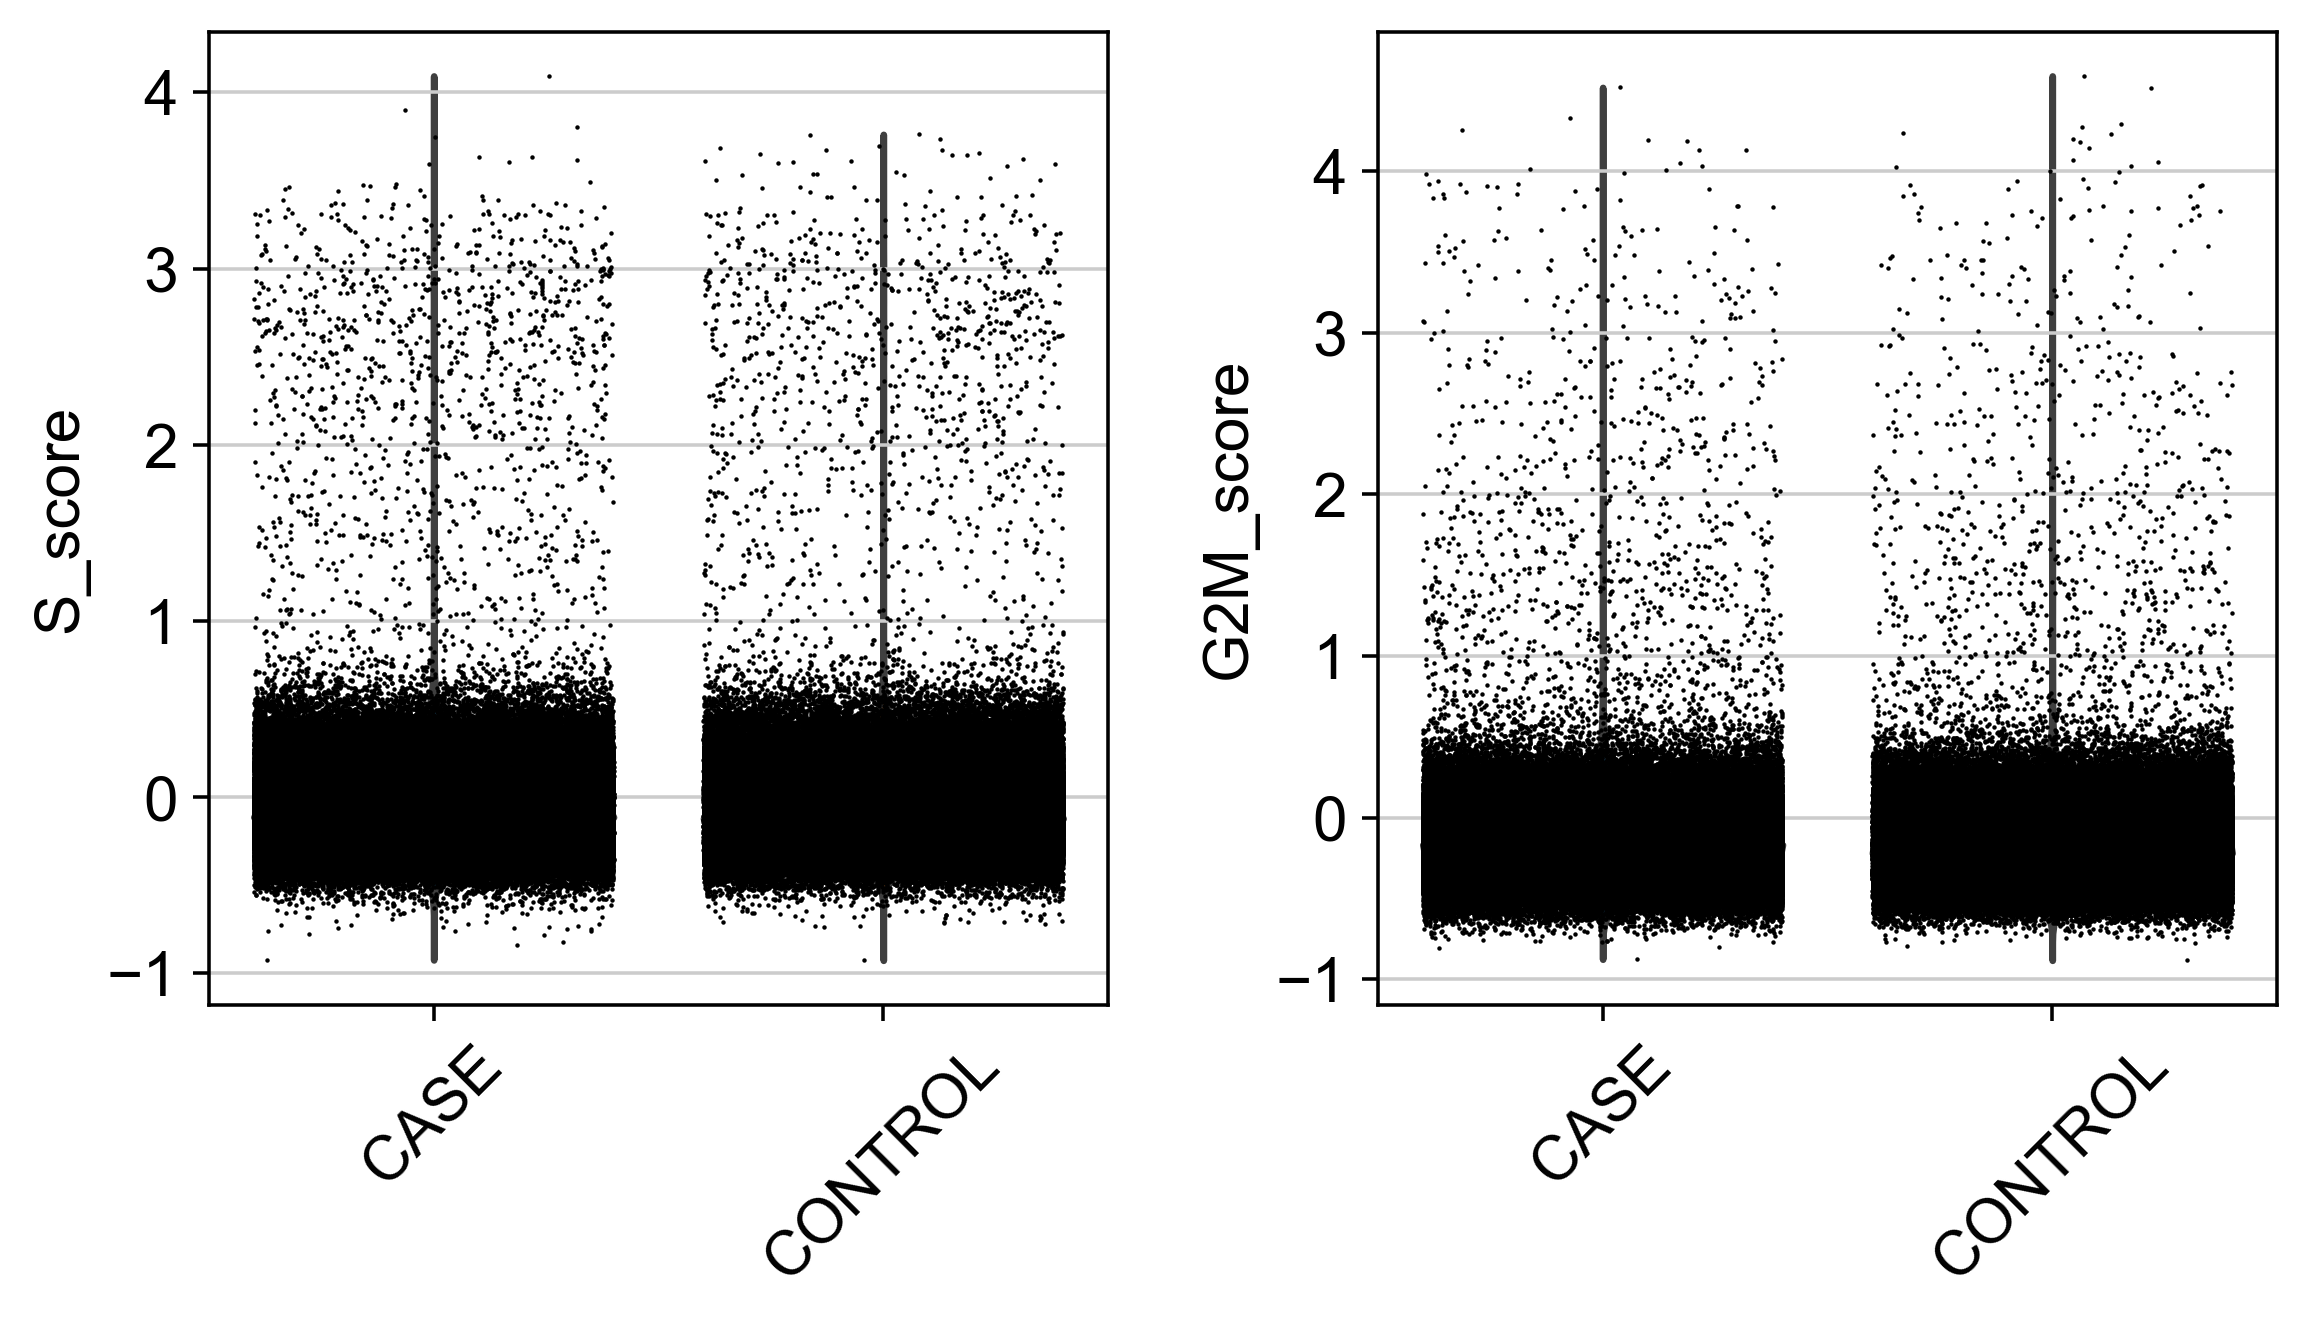

In [ ]:
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.4, groupby = 'TB_status', rotation = 45)

In [ ]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'TB_status_colors', 'cluster_ids_colors'

In [ ]:
sample_object.obs

,cell_id,nUMI,nGene,percent_mito,batch,TB_status,UMAP_1,UMAP_2,cluster_name,cluster_ids,...,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,percent_mt2,n_counts,percent_chrY,XIST-counts,S_score,G2M_score
0,AAACCCAAGGCCTAAG-1,6108,1557,0.055828,1,CASE,-2.743703,1.617194,CD4+ CD27+,C-2,...,341.0,5.582842,2469.0,40.422398,0.055828,6108.0,0.000000,2.0,-0.093816,-0.092167
1,AAACCCAAGGTTCTTG-1,7902,2149,0.083017,1,CASE,-4.237045,0.306832,CD4+ CCR4+ central,C-3,...,656.0,8.301696,2759.0,34.915211,0.083017,7902.0,0.000000,2.0,0.034162,0.069691
2,AAACCCAAGTGCAGGT-1,5033,1788,0.129744,1,CASE,-1.136187,-4.012949,CD4+ Treg,C-9,...,653.0,12.974369,1289.0,25.610968,0.129744,5033.0,0.000000,3.0,-0.188475,-0.092411
3,AAACCCACAAGAGTAT-1,6574,1747,0.066930,1,CASE,-1.015078,3.789505,CD4+ CD27+CD161+,C-4,...,440.0,6.693033,2674.0,40.675388,0.066930,6574.0,0.000000,2.0,-0.313206,-0.220999
4,AAACCCACACACGGTC-1,6471,1872,0.047442,1,CASE,0.658381,2.427080,CD4+ Th17/1,C-13,...,307.0,4.744244,2310.0,35.697727,0.047442,6471.0,0.108175,0.0,0.085200,-0.283257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500084,TTTGTTGTCCGCCTAT-46,1945,833,0.183033,46,CASE,-2.568426,0.780417,CD4+ CD27+,C-2,...,356.0,18.303343,114.0,5.861183,0.183033,1945.0,0.205656,0.0,-0.170059,-0.077589
500085,TTTGTTGTCCTGGGTG-46,4534,1537,0.051610,46,CONTROL,1.017550,-0.594416,CD4+ Th1,C-17,...,234.0,5.161005,1161.0,25.606527,0.051610,4534.0,0.000000,2.0,-0.409021,0.004456
500086,TTTGTTGTCGATGGAG-46,3157,1013,0.081723,46,CASE,2.301589,0.623997,CD4+ Th17/1,C-16,...,258.0,8.172316,1231.0,38.992714,0.081723,3157.0,0.000000,0.0,-0.274890,-0.344508
500087,TTTGTTGTCGTTTACT-46,3675,1202,0.089252,46,CASE,0.572390,-1.264730,CD4+ Th1,C-17,...,328.0,8.925170,1167.0,31.755102,0.089252,3675.0,0.108844,0.0,-0.302021,-0.004451


### Predict doublets

In [ ]:
holder = np.zeros((sample_object.shape[0],))
for smp in np.unique(sample_object.obs['batch']):
    if smp == []:
        continue
    adata_smp = sample_object[sample_object.obs['batch'] == smp]
    scrub = scr.Scrublet(adata_smp.X)
    adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
    holder[sample_object.obs['batch'] == smp] = adata_smp.obs['predicted_doublets']
sample_object.obs['predicted_doublets'] = holder

sum(sample_object.obs['predicted_doublets'])
sample_object

/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:


Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.3%
Elapsed time: 9.7 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.5%
Elapsed time: 9.4 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 8.8 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.7%
Elapsed time: 8.9 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.76
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.6%
Elapsed time: 7.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 9.1 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 30.8%
Elapsed time: 8.1 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 40.0%
Elapsed time: 8.2 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.5%
Elapsed time: 7.3 seconds


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:


Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.80
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 13.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 7.9 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%
Elapsed time: 8.7 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.3%
Elapsed time: 8.2 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 23.3%
Elapsed time: 9.9 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.73
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 10.3 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 20.0%
Elapsed time: 9.8 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.7%
Elapsed time: 7.4 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 9.4 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.4%
Elapsed time: 10.1 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.8%
Elapsed time: 8.7 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 8.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.66
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 13.3%
Elapsed time: 7.7 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.71
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.0%
Elapsed time: 8.2 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 31.6%
Elapsed time: 8.6 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.0%
Elapsed time: 11.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.80
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 9.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.4%
Elapsed time: 10.9 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.75
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 7.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.76
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 6.4 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.80
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 11.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.72
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.3%
Elapsed time: 9.0 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 8.5 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.9%
Elapsed time: 8.7 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.81
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 10.6 seconds


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:


Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.74
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 40.0%
Elapsed time: 12.6 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.81
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 11.6 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.80
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 14.4 seconds


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:


Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.81
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 12.3 seconds


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:


Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.76
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 17.6 seconds


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:


Preprocessing...


/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.69
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 13.7 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 12.5%
Elapsed time: 8.8 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.7%
Elapsed time: 14.3 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.78
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.7%
Elapsed time: 8.8 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.80
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 20.0%
Elapsed time: 11.3 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.80
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.6%
Elapsed time: 12.1 seconds
Preprocessing...


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()
/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if smp == []:
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/opt/homebrew/Caskroom/mambaforge/base/envs/scanpy_v1.9.1/lib/python3.10/site-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.79
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 28.6%
Elapsed time: 10.6 seconds


/var/folders/g6/vfgrx_y95ml0h2lsgfx4jg6jwvdsz3/T/ipykernel_3107/1222061682.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_smp.obs['doublet_scores'], adata_smp.obs['predicted_doublets'] = scrub.scrub_doublets()


AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'TB_status_colors', 'cluster_ids_colors'

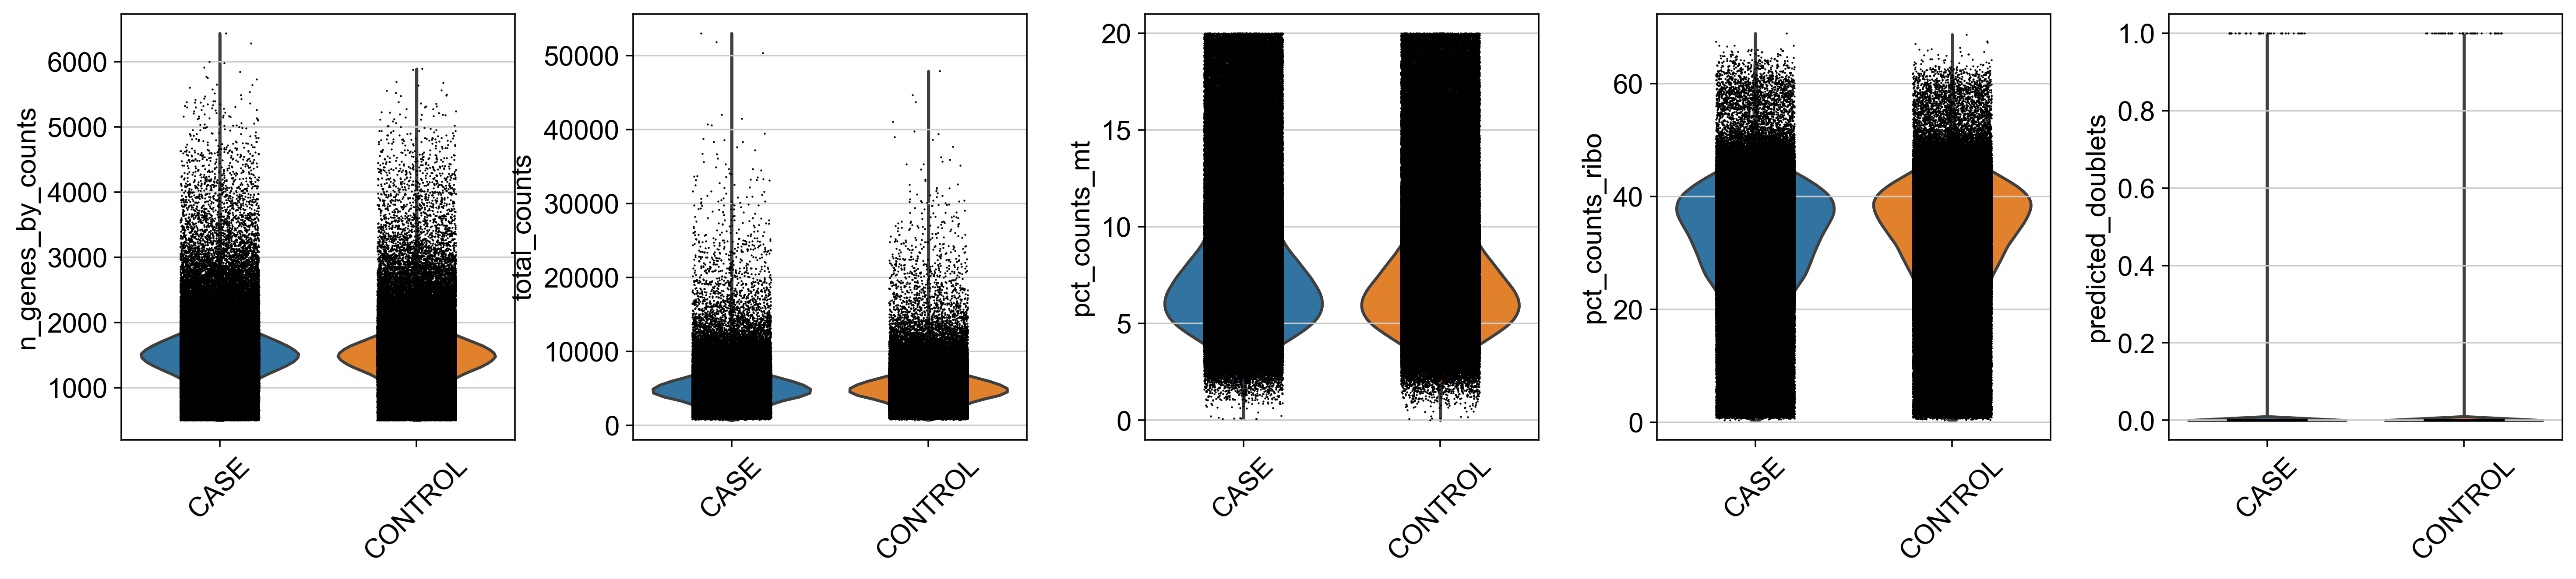

In [ ]:
#check if our predicted doublets also have more detected genes in general; what would be the number required to raise suspicions?

sc.pl.violin(sample_object, ['n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'predicted_doublets'],
             jitter = 0.2, groupby = 'TB_status', rotation = 45)

### Prepare counts for individual slots

In [ ]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:08)


AnnData object with n_obs × n_vars = 500089 × 33538
    obs: 'cell_id', 'nUMI', 'nGene', 'percent_mito', 'batch', 'TB_status', 'UMAP_1', 'UMAP_2', 'cluster_name', 'cluster_ids', 'donor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt2', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'predicted_doublets'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'TB_status_colors', 'cluster_ids_colors'
    layers: 'counts', 'sqrt_norm'

### Export object

In [ ]:
sample_object.write('/lustre/groups/talaveralopez/datasets/mairi_tb_curation/output_files/230209_Nathan_preprocessed_MM.h5ad')
